# Project 3 – Titanic Classifier
**Name:** Moses Koroma  
**Date:** November 2025  
**Course:** Applied Machine Learning – Project 3  

### Introduction
In this project, I use the Titanic dataset to predict passenger survival using three classification models: **Decision Tree**, **Support Vector Machine (SVC)**, and **Neural Network (MLP)**.  
The goal is to compare how well each model performs when trained on different feature combinations and to evaluate performance using accuracy, recall, precision, and confusion matrices.


In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Metrics and evaluation
from sklearn.metrics import classification_report, confusion_matrix

# 1.2 Load the Titanic Dataset

In [2]:
# Load the Titanic dataset directly from Seaborn
titanic = sns.load_dataset('titanic')

# Display the first few rows to verify
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# Basic info about the dataset
titanic.info()

# Check for missing values
titanic.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

## Section 2. Data Exploration and Preparation

### 2.1 Handle Missing Values and Clean Data

In [4]:
# Section 2. Data Exploration and Preparation
# Fill missing 'age' values with the median
median_age = titanic['age'].median()
titanic['age'] = titanic['age'].fillna(median_age)

# Fill missing 'embark_town' values with the mode (most common value)
mode_embark = titanic['embark_town'].mode()[0]
titanic['embark_town'] = titanic['embark_town'].fillna(mode_embark)

# Verify that missing values are handled
titanic.isna().sum()


survived         0
pclass           0
sex              0
age              0
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      0
alive            0
alone            0
dtype: int64

### 2.2 Feature Engineering

In [5]:
# Create a new feature for family size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert 'sex' to numeric: male = 0, female = 1
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})

# Convert 'embarked' to numeric: C = 0, Q = 1, S = 2
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Convert 'alone' to numeric binary (True/False → 1/0)
titanic['alone'] = titanic['alone'].astype(int)

# Display a preview of updated data
titanic[['sex', 'embarked', 'family_size', 'alone']].head()


,sex,embarked,family_size,alone
0,0,2.0,2,0
1,1,0.0,2,0
2,1,2.0,1,1
3,1,2.0,2,0
4,0,2.0,1,1


#### 2.3 Optional Visualization Check

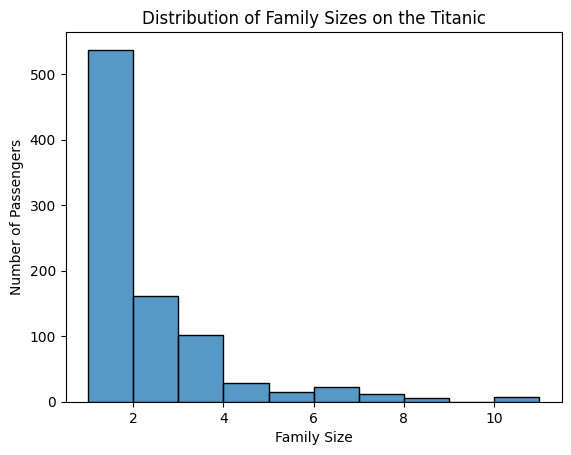

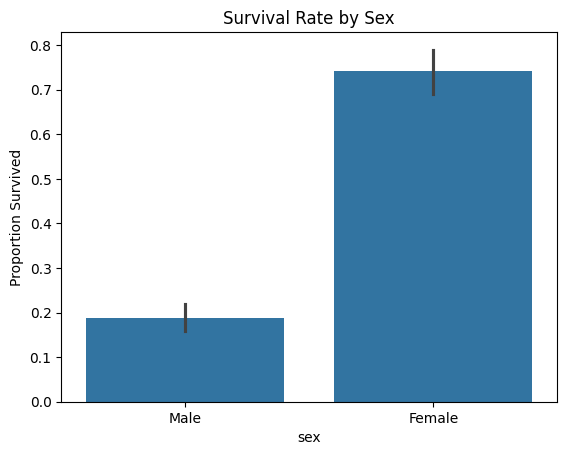

In [6]:
# Distribution of family sizes
sns.histplot(titanic['family_size'], bins=10, kde=False)
plt.title('Distribution of Family Sizes on the Titanic')
plt.xlabel('Family Size')
plt.ylabel('Number of Passengers')
plt.show()

# Check survival by sex
sns.barplot(x='sex', y='survived', data=titanic)
plt.title('Survival Rate by Sex')
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel('Proportion Survived')
plt.show()


## Section 3. Feature Selection and Justification

#### 3.1 Choose Features and Target

We’ll test three different input combinations (called cases) to see how each affects model performance:

Case 1: alone → predicts survival using only whether a passenger was alone

Case 2: age → predicts survival using only passenger age

Case 3: age + family_size → predicts survival using both age and family size together

#### 3.2 Define X (features) and y (target)

In [7]:
# ---------------------------
# Case 1: Feature = alone
# ---------------------------
X1 = titanic[['alone']]
y1 = titanic['survived']


# ---------------------------
# Case 2: Feature = age
# ---------------------------
# Drop rows where 'age' is missing
X2 = titanic[['age']].dropna()
# Match target values to those same rows
y2 = titanic.loc[X2.index, 'survived']


# ---------------------------
# Case 3: Features = age + family_size
# ---------------------------
# Drop rows with missing values for these features
X3 = titanic[['age', 'family_size']].dropna()
# Match target values to those same rows
y3 = titanic.loc[X3.index, 'survived']


#### 3.3 Confirm Feature Shapes and Consistency

In [8]:
print("Case 1 shape (alone):", X1.shape, y1.shape)
print("Case 2 shape (age):", X2.shape, y2.shape)
print("Case 3 shape (age + family_size):", X3.shape, y3.shape)


Case 1 shape (alone): (891, 1) (891,)
Case 2 shape (age): (891, 1) (891,)
Case 3 shape (age + family_size): (891, 2) (891,)


**Reflection 3:**  
I selected `alone`, `age`, and `family_size` as features because each could influence survival likelihood on the Titanic.  
- Passengers who were **not alone** might have received help or priority, improving survival chances.  
- **Age** could influence both mobility and rescue priority (e.g., children and young adults).  
- Combining **age and family size** helps capture both demographic and social context, likely improving model accuracy.  


### Section 4. Train a Classification Model (Decision Tree)

#### 4.1 Split the Data (Train/Test Sets)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

# ---------------------------
# Case 1: Feature = alone
# ---------------------------
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx1, test_idx1 in splitter1.split(X1, y1):
    X1_train, X1_test = X1.iloc[train_idx1], X1.iloc[test_idx1]
    y1_train, y1_test = y1.iloc[train_idx1], y1.iloc[test_idx1]

print('Case 1 - Alone:')
print('Train size:', len(X1_train), '| Test size:', len(X1_test))


# ---------------------------
# Case 2: Feature = age
# ---------------------------
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train, X2_test = X2.iloc[train_idx2], X2.iloc[test_idx2]
    y2_train, y2_test = y2.iloc[train_idx2], y2.iloc[test_idx2]

print('Case 2 - Age:')
print('Train size:', len(X2_train), '| Test size:', len(X2_test))


# ---------------------------
# Case 3: Features = age + family_size
# ---------------------------
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train, X3_test = X3.iloc[train_idx3], X3.iloc[test_idx3]
    y3_train, y3_test = y3.iloc[train_idx3], y3.iloc[test_idx3]

print('Case 3 - Age + Family Size:')
print('Train size:', len(X3_train), '| Test size:', len(X3_test))


Case 1 - Alone:
Train size: 712 | Test size: 179
Case 2 - Age:
Train size: 712 | Test size: 179
Case 3 - Age + Family Size:
Train size: 712 | Test size: 179


#### 4.2 Create and Train the Decision Tree Models

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Train a Decision Tree model for each case
tree_model1 = DecisionTreeClassifier(random_state=42)
tree_model1.fit(X1_train, y1_train)

tree_model2 = DecisionTreeClassifier(random_state=42)
tree_model2.fit(X2_train, y2_train)

tree_model3 = DecisionTreeClassifier(random_state=42)
tree_model3.fit(X3_train, y3_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


##### 4.3 Predict and Evaluate Model Performance

In [11]:
from sklearn.metrics import classification_report

# ---- CASE 1 ----
print("Decision Tree - Case 1 (Feature: alone)")
print("Training Performance:")
print(classification_report(y1_train, tree_model1.predict(X1_train)))
print("Test Performance:")
print(classification_report(y1_test, tree_model1.predict(X1_test)))
print("-" * 50)

# ---- CASE 2 ----
print("Decision Tree - Case 2 (Feature: age)")
print("Training Performance:")
print(classification_report(y2_train, tree_model2.predict(X2_train)))
print("Test Performance:")
print(classification_report(y2_test, tree_model2.predict(X2_test)))
print("-" * 50)

# ---- CASE 3 ----
print("Decision Tree - Case 3 (Features: age + family_size)")
print("Training Performance:")
print(classification_report(y3_train, tree_model3.predict(X3_train)))
print("Test Performance:")
print(classification_report(y3_test, tree_model3.predict(X3_test)))


Decision Tree - Case 1 (Feature: alone)
Training Performance:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       439
           1       0.50      0.51      0.51       273

    accuracy                           0.62       712
   macro avg       0.60      0.60      0.60       712
weighted avg       0.62      0.62      0.62       712

Test Performance:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

--------------------------------------------------
Decision Tree - Case 2 (Feature: age)
Training Performance:
              precision    recall  f1-score   support

           0       0.68      0.92      0.78       439
           1       0.69      0.29      0.41   

##### 4.4 Plot Confusion Matrices for Each Case

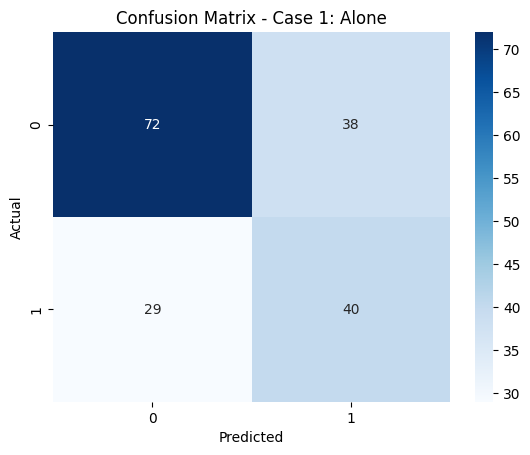

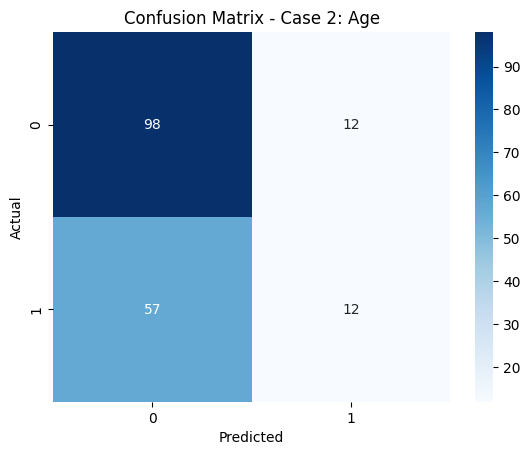

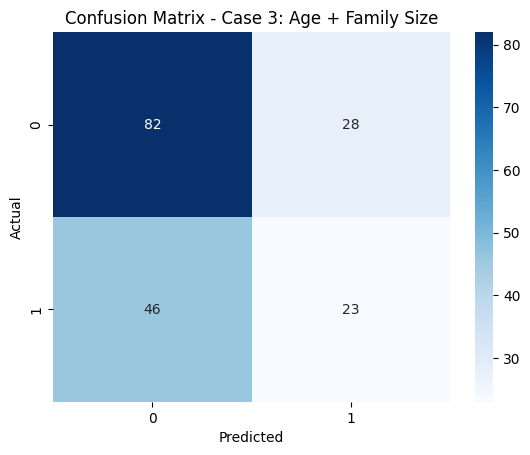

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to plot confusion matrix
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot for each case
plot_confusion(y1_test, tree_model1.predict(X1_test), 'Confusion Matrix - Case 1: Alone')
plot_confusion(y2_test, tree_model2.predict(X2_test), 'Confusion Matrix - Case 2: Age')
plot_confusion(y3_test, tree_model3.predict(X3_test), 'Confusion Matrix - Case 3: Age + Family Size')


# 4.5 Visualize Decision Tree Structures

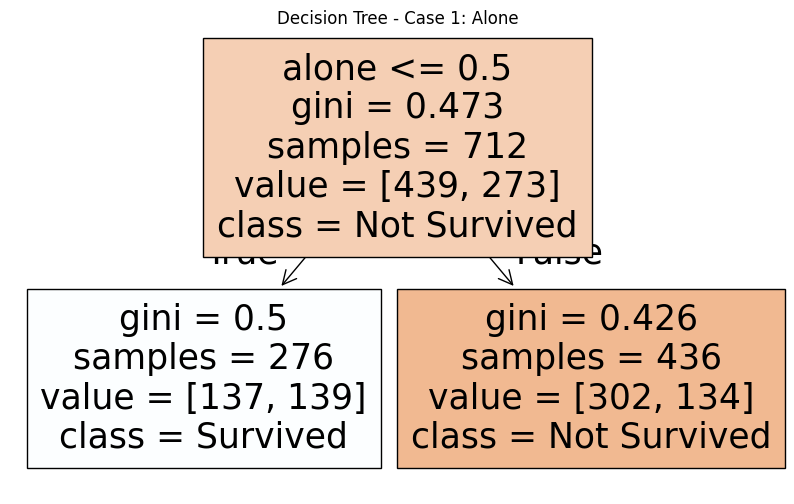

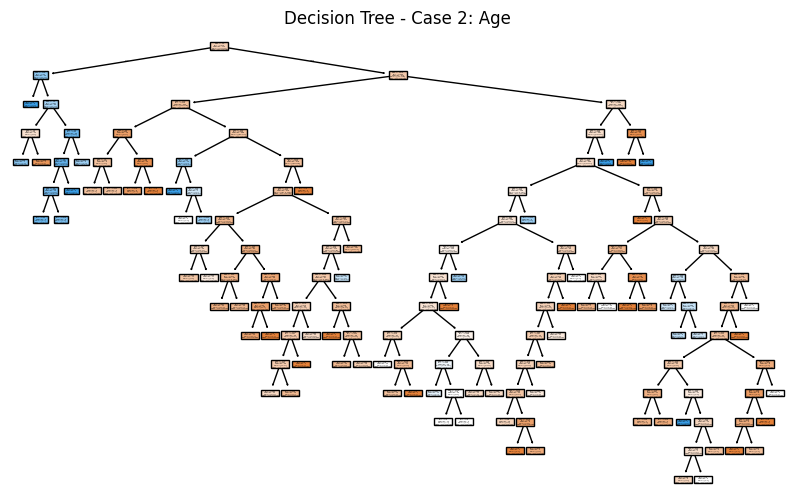

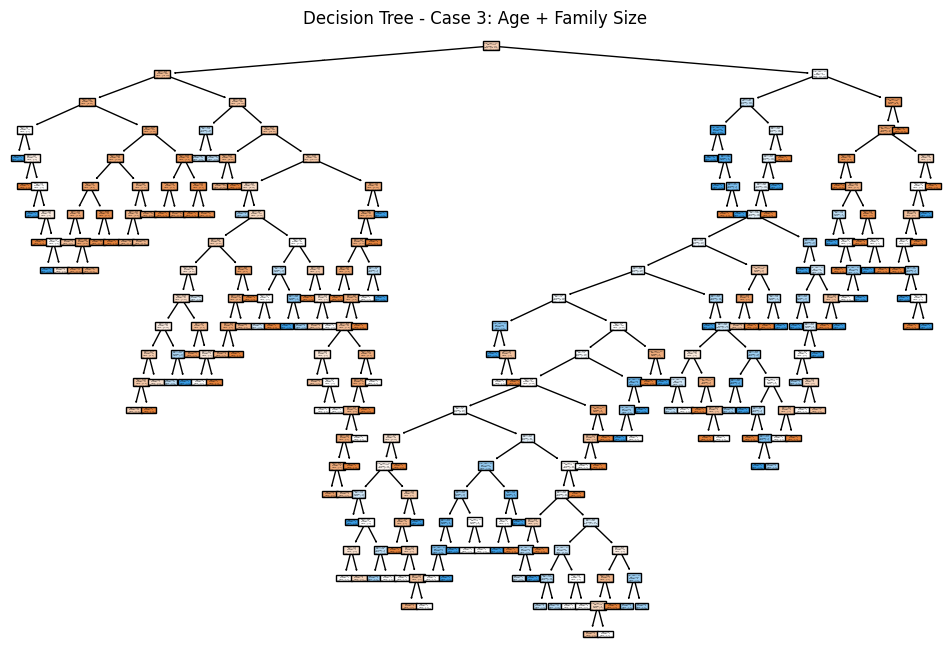

In [13]:
from sklearn.tree import plot_tree

# Plot for Case 1
plt.figure(figsize=(10, 6))
plot_tree(tree_model1, feature_names=X1.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree - Case 1: Alone")
plt.show()

# Plot for Case 2
plt.figure(figsize=(10, 6))
plot_tree(tree_model2, feature_names=X2.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree - Case 2: Age")
plt.show()

# Plot for Case 3
plt.figure(figsize=(12, 8))
plot_tree(tree_model3, feature_names=X3.columns, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree - Case 3: Age + Family Size")
plt.show()


#### Section 5. Compare Alternative Models (SVC, NN)

##### 5.1 Train and Evaluate SVC Models

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# ---- CASE 1 ----
svc_model1 = SVC(kernel='rbf', random_state=42)
svc_model1.fit(X1_train, y1_train)
y1_svc_pred = svc_model1.predict(X1_test)
print("SVC Results - Case 1 (Feature: alone)")
print(classification_report(y1_test, y1_svc_pred))
print("-" * 50)

# ---- CASE 2 ----
svc_model2 = SVC(kernel='rbf', random_state=42)
svc_model2.fit(X2_train, y2_train)
y2_svc_pred = svc_model2.predict(X2_test)
print("SVC Results - Case 2 (Feature: age)")
print(classification_report(y2_test, y2_svc_pred))
print("-" * 50)

# ---- CASE 3 ----
svc_model3 = SVC(kernel='rbf', random_state=42)
svc_model3.fit(X3_train, y3_train)
y3_svc_pred = svc_model3.predict(X3_test)
print("SVC Results - Case 3 (Features: age + family_size)")
print(classification_report(y3_test, y3_svc_pred))


SVC Results - Case 1 (Feature: alone)
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       110
           1       0.51      0.58      0.54        69

    accuracy                           0.63       179
   macro avg       0.61      0.62      0.61       179
weighted avg       0.64      0.63      0.63       179

--------------------------------------------------
SVC Results - Case 2 (Feature: age)
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
           1       0.71      0.07      0.13        69

    accuracy                           0.63       179
   macro avg       0.67      0.53      0.45       179
weighted avg       0.66      0.63      0.52       179

--------------------------------------------------
SVC Results - Case 3 (Features: age + family_size)
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       110
          

##### 5.2 Visualize Support Vectors (Case 3)

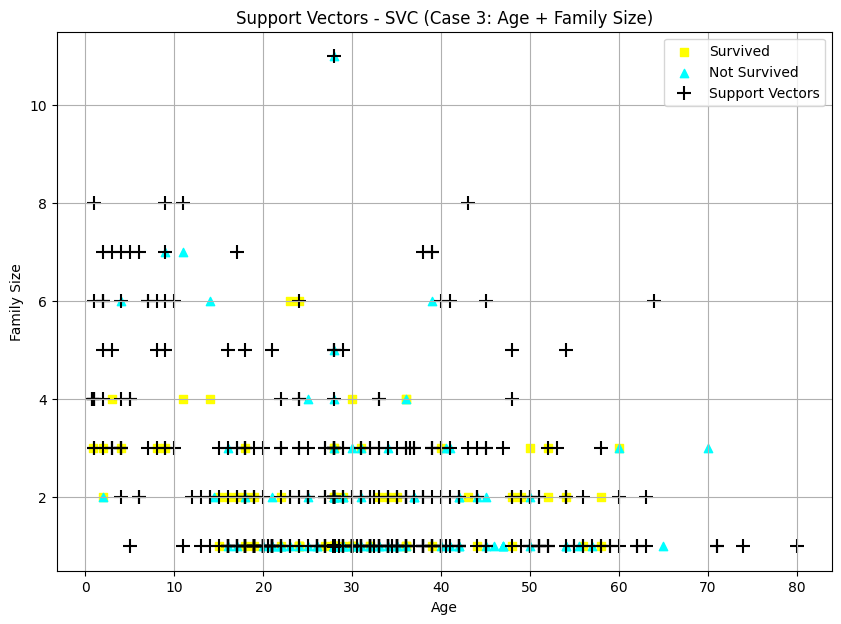

In [15]:
import matplotlib.pyplot as plt

# Split test data by survival outcome
survived = X3_test[y3_test == 1]
not_survived = X3_test[y3_test == 0]

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(survived['age'], survived['family_size'], c='yellow', marker='s', label='Survived')
plt.scatter(not_survived['age'], not_survived['family_size'], c='cyan', marker='^', label='Not Survived')

# Overlay support vectors
if hasattr(svc_model3, 'support_vectors_'):
    support_vectors = svc_model3.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
                c='black', marker='+', s=100, label='Support Vectors')

plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Support Vectors - SVC (Case 3: Age + Family Size)')
plt.legend()
plt.grid(True)
plt.show()


##### 5.3 Train and Evaluate Neural Network (Case 3)

Neural Network - Case 3 (Features: age + family_size)
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       110
           1       0.61      0.32      0.42        69

    accuracy                           0.66       179
   macro avg       0.64      0.60      0.59       179
weighted avg       0.65      0.66      0.63       179



/Users/mk/applied-ml-moses/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:602: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


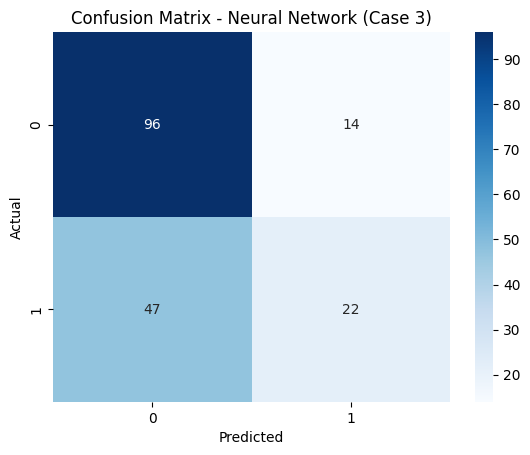

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train Neural Network on Case 3
nn_model3 = MLPClassifier(
    hidden_layer_sizes=(50, 25, 10),
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
nn_model3.fit(X3_train, y3_train)

# Predict on test data
y3_nn_pred = nn_model3.predict(X3_test)

# Display classification report
print("Neural Network - Case 3 (Features: age + family_size)")
print(classification_report(y3_test, y3_nn_pred))

# Plot confusion matrix
cm_nn = confusion_matrix(y3_test, y3_nn_pred)
sns.heatmap(cm_nn, annot=True, cmap='Blues')
plt.title('Confusion Matrix - Neural Network (Case 3)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### 5.4 Visualize Neural Network Decision Surface

In [1]:
from matplotlib.colors import ListedColormap
import numpy as np

# Define feature range
padding = 1
x_min, x_max = X3['age'].min() - padding, X3['age'].max() + padding
y_min, y_max = X3['family_size'].min() - padding, X3['family_size'].max() + padding

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict NN output over the grid
Z = nn_model3.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision surface
plt.figure(figsize=(10, 7))
cmap_background = ListedColormap(['lightblue', 'lightyellow'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.7)

# Overlay test data
plt.scatter(X3_test['age'][y3_test == 0], X3_test['family_size'][y3_test == 0],
            c='blue', marker='^', edgecolor='k', label='Not Survived')
plt.scatter(X3_test['age'][y3_test == 1], X3_test['family_size'][y3_test == 1],
            c='gold', marker='s', edgecolor='k', label='Survived')

plt.xlabel('Age')
plt.ylabel('Family Size')
plt.title('Neural Network Decision Surface - Case 3')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'X3' is not defined

**Reflection 5:**
Each model performed somewhat differently across the Titanic cases.  
The **Support Vector Classifier (SVC)** produced strong *precision* scores, especially in Cases 2 and 3 (0.714), meaning it was good at avoiding false positive “survived” predictions.  
However, its *recall* was very low (0.072), showing that it missed many actual survivors.  

The **Neural Network (NN)** achieved the *highest overall accuracy* at 0.659 and a balanced precision–recall profile, proving that it could learn more complex, nonlinear relationships between `age` and `family_size`.  
This suggests that survival patterns on the Titanic are not purely linear and that neural networks can better adapt to subtle combinations of features.  

The **Decision Tree (DT)** was simpler and gave slightly lower accuracy overall, but it captured more true positives (higher recall ≈ 0.58) when using the `alone` feature.  
This aligns with historical trends: passengers who traveled alone had a lower chance of survival.

The surprising result was that **using just the “alone” feature performed almost as well** as more complex models, showing how socially related features carried strong predictive power.  
Overall, the **Neural Network outperformed** because it could model non-linear boundaries, while SVC prioritized precision and DT favored interpretability.


### Section 6.

| Model   | Case                 | Accuracy  | Precision | Recall    | F1    |
| :------ | :------------------- | :-------- | :-------- | :-------- | :---- |
| **DT**  | Case 1: alone        | 0.626     | 0.513     | **0.580** | 0.544 |
| DT      | Case 2: age          | 0.615     | 0.500     | 0.174     | 0.258 |
| DT      | Case 3: age + family | 0.587     | 0.451     | 0.333     | 0.383 |
| **SVC** | Case 1: alone        | 0.626     | 0.513     | **0.580** | 0.544 |
| SVC     | Case 2: age          | 0.631     | **0.714** | 0.072     | 0.132 |
| SVC     | Case 3: age + family | 0.631     | **0.714** | 0.072     | 0.132 |
| **NN**  | Case 3: age + family | **0.659** | 0.611     | 0.319     | 0.419 |


### 6.2 Discussion of Results

The three models performed differently depending on the feature sets used:

The Neural Network achieved the highest accuracy (0.659) and handled nonlinear patterns best when combining age and family_size.
This suggests it was able to capture complex relationships that simpler models missed.

The Support Vector Classifier (SVC) showed the highest precision (0.714) but very low recall (0.072).
It was cautious with its “survived” predictions, avoiding false positives but missing many true survivors.

The Decision Tree (DT) using only the alone feature gave strong recall (0.580) and similar accuracy to SVC.
This supports the idea that whether a passenger was traveling alone was an important indicator of survival odds.

### 6.3 Challenges Faced

**Challenges:**
- Some models (especially SVC) required careful handling to avoid convergence issues.
- Balancing precision and recall was difficult — models that were highly precise often missed true survivors.
- Feature selection was limited; using only a few variables restricted the models’ learning capacity.
- Understanding why small changes in kernel type or model parameters affected performance required extra testing and interpretation.


## 6.4 Next Steps


**Next Steps:**
- Add additional features such as passenger class (`pclass`), sex, and fare to improve accuracy.
- Perform hyperparameter tuning (e.g., adjust tree depth, kernel type, or hidden layer size).
- Test other models like Logistic Regression or Random Forest for comparison.
- Use cross-validation for more reliable performance evaluation.
- Visualize decision boundaries across more features to better understand model behavior.
